# 库导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
import time
import scipy

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 相关交易日

## 交易日期数据

In [2]:
TradeDateDf = pd.read_csv('D:/DWDB/%s.csv'%('AShareCalendar'))
TradeDateDf = TradeDateDf[TradeDateDf['S_INFO_EXCHMARKET'] == 'SSE']
TradeDateDf_D = TradeDateDf['TRADE_DAYS'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d')).to_frame('TRADE_DAYS').sort_values('TRADE_DAYS')

TradeDateDf_D_Used = TradeDateDf_D[(TradeDateDf_D['TRADE_DAYS']>='2005-01-01') & (TradeDateDf_D['TRADE_DAYS']<='2019-07-31')]
TradeDateDf_D_Used.index = TradeDateDf_D_Used['TRADE_DAYS']
TradeDateDf_D_Used.index.names = ['NOT_TRADE_DAYS']

TradeDateDf_M_Used = TradeDateDf_D_Used.resample('M').last()
TradeDateDf_M_Used.index.names = ['NOT_TRADE_DAYS']

## 日期转换函数

In [3]:
# 月度非标准数据的日期转变为当月（若t>t_end，下个月）最后一个交易日
def MdateToMENDdate(FinancialIndicatorDf,TradeDateDf_M_Used,colname):
    '''
    第1参数，DF，包含 colname 列，公告日期，
    第2参数，DF，包含 TRADE_DAYS 列，为月度交易日，
    '''
    FinancialIndicatorDf_1 = FinancialIndicatorDf.copy()
    FinancialIndicatorDf_end = FinancialIndicatorDf.copy()
    ## 可更改，根据ANN_DT列是否为日期
    try:
        FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
    except:
        FinancialIndicatorDf_1['TRADE_DAYS_tmp'] = FinancialIndicatorDf_1[colname]
    #################################
    TradeDateDf_M_Used_ = TradeDateDf_M_Used.copy()
    TradeDateDf_M_Used_['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in TradeDateDf_M_Used['TRADE_DAYS'].tolist()].copy()
    FinancialIndicatorDf_1['TRADE_DAYS_Y_M'] = [each.strftime('%Y-%m-%d')[:7] for each in FinancialIndicatorDf_1['TRADE_DAYS_tmp'].tolist()]
    FinancialIndicatorDf_2 = FinancialIndicatorDf_1.merge(TradeDateDf_M_Used_,on=['TRADE_DAYS_Y_M'],how='left')
    TradeDateDf_M_Used_DateList = TradeDateDf_M_Used_['TRADE_DAYS'].tolist()
    FinancialIndicatorDf_3 = FinancialIndicatorDf_2.copy()
#     FinancialIndicatorDf_3['TRADE_DAYS'] = FinancialIndicatorDf_3.apply(lambda x: 
#                                                                         TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
#                                                                         if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
#                                                                         else x['TRADE_DAYS'] ,axis=1)
    FinancialIndicatorDf_end[colname]= FinancialIndicatorDf_3.apply(lambda x: 
                                                                        TradeDateDf_M_Used_DateList[TradeDateDf_M_Used_DateList.index(x['TRADE_DAYS'])+1] 
                                                                        if x['TRADE_DAYS_tmp']>x['TRADE_DAYS'] 
                                                                        else x['TRADE_DAYS'] ,axis=1)
    return FinancialIndicatorDf_end

# 股票池筛选

## 获取全股票池

In [4]:
# 以行情信息对应的日度股票列表筛选得到月度可选股列表
DfForStock = pd.read_csv('D:/DWDB/%s.csv'%('AShareEODPrices'))
DfForStock_0 = DfForStock[['S_INFO_WINDCODE','TRADE_DT']].copy()
DfForStock_0['TRADE_DAYS'] = DfForStock_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
DfForStock_0=DfForStock_0[['S_INFO_WINDCODE','TRADE_DAYS']].copy()

In [5]:
# 日度股票列表月度化
DfForStock_1=DfForStock_0.set_index('TRADE_DAYS')
DfForStock_1['TRADE_DAYS']=DfForStock_1.index
DfForStock_2=DfForStock_1.groupby('S_INFO_WINDCODE').apply(lambda x:x.resample('M').last())
DfForStock_3=DfForStock_2.reset_index(drop=True)

## 删除上市未满6个月股票

In [6]:
IPODF = pd.read_csv('D:/DWDB/%s.csv'%'AShareIPO')
IPODF['S_IPO_LISTDATE']=IPODF['S_IPO_LISTDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
IPODF_0 = IPODF[['S_INFO_WINDCODE','S_IPO_LISTDATE']]

DfForStock_4 = DfForStock_3.merge(IPODF_0,on=['S_INFO_WINDCODE'],how='left')
DfForStock_4['IPOtitlNow'] = DfForStock_4['TRADE_DAYS']-DfForStock_4['S_IPO_LISTDATE']
DfForStock_4['IPOtitlNowIF'] = DfForStock_4['IPOtitlNow'].apply(lambda x: 1 if x.days>182 else 0)

DfForStock_5 = DfForStock_4[DfForStock_4['IPOtitlNowIF']==1][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

## 删除有特殊处理的股票

In [7]:
STDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareST')
STDF['ENTRY_DT'] = STDF['ENTRY_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
STDF['REMOVE_DT'] = STDF['REMOVE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
STDF_0 = STDF[['S_INFO_WINDCODE','ENTRY_DT','REMOVE_DT','S_TYPE_ST']].copy()
STDF_0['REMOVE_DT'] = STDF_0['REMOVE_DT'].fillna(datetime.datetime.strptime('2099-12-31','%Y-%m-%d'))

In [8]:
DfForStock_6=DfForStock_5.merge(STDF_0,left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['ENTRY_DT','S_INFO_WINDCODE'],how='left')
DfForStock_6=DfForStock_6[DfForStock_6['ENTRY_DT'].isnull()][['TRADE_DAYS','S_INFO_WINDCODE']].copy()
DfForStock_7=DfForStock_6.merge(MdateToMENDdate(STDF_0,TradeDateDf_M_Used,'ENTRY_DT'),left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['ENTRY_DT','S_INFO_WINDCODE'],how='left')

In [9]:
def FillNaT(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    df_=df_.fillna(method='ffill')
    return df_
DfForStock_8=DfForStock_7.groupby('S_INFO_WINDCODE').apply(FillNaT).reset_index(drop=True)

In [10]:
DfForStock_9=DfForStock_8[~(DfForStock_8['TRADE_DAYS']<=DfForStock_8['REMOVE_DT'])][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

## 剔除停牌股票

In [11]:
TradingSuspensionDF = pd.read_csv('D:/DWDB/%s.csv'%'AShareTradingSuspension')
TradingSuspensionDF_0 = TradingSuspensionDF[['S_INFO_WINDCODE','S_DQ_SUSPENDDATE','S_DQ_RESUMPDATE']].copy()
TradingSuspensionDF_0['S_DQ_SUSPENDDATE']=TradingSuspensionDF_0['S_DQ_SUSPENDDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)
TradingSuspensionDF_0['S_DQ_RESUMPDATE']=TradingSuspensionDF_0['S_DQ_RESUMPDATE'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not np.isnan(x) else np.nan)

TradingSuspensionDF_1=TradingSuspensionDF_0.copy()
TradingSuspensionDF_1['S_DQ_RESUMPDATE']=TradingSuspensionDF_1.apply(lambda x: x['S_DQ_SUSPENDDATE'] if pd.isnull(x['S_DQ_RESUMPDATE']) else x['S_DQ_RESUMPDATE'],axis=1)

TradingSuspensionDF_2=MdateToMENDdate(TradingSuspensionDF_1,TradeDateDf_M_Used,'S_DQ_SUSPENDDATE')
TradingSuspensionDF_3=TradingSuspensionDF_2[~(TradingSuspensionDF_2['S_DQ_SUSPENDDATE']>TradingSuspensionDF_2['S_DQ_RESUMPDATE'])]

DfForStock_10=DfForStock_9.merge(TradingSuspensionDF_3,left_on=['TRADE_DAYS','S_INFO_WINDCODE'],right_on=['S_DQ_SUSPENDDATE','S_INFO_WINDCODE'],how='left')
DfForStock_11=DfForStock_10.groupby('S_INFO_WINDCODE').apply(FillNaT).reset_index(drop=True)
DfForStock_12=DfForStock_11[~(DfForStock_11['TRADE_DAYS']<=DfForStock_11['S_DQ_RESUMPDATE'])][['S_INFO_WINDCODE','TRADE_DAYS']].copy()

DfForStock_V = DfForStock_12.copy()

# 动量因子计算
## 多窗口动量因子

In [17]:
AllPriceData=DfForStock.copy()
AllPriceData_0 = AllPriceData[['S_INFO_WINDCODE','TRADE_DT','S_DQ_ADJCLOSE']].copy()
AllPriceData_0['TRADE_DAYS'] = AllPriceData_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not pd.isnull(x) else np.nan)
AllPriceData_1=AllPriceData_0[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()

In [18]:
AllPriceData_1.head()

,S_INFO_WINDCODE,TRADE_DAYS,S_DQ_ADJCLOSE
0,000878.SZ,2005-01-04,8.12
1,000880.SZ,2005-01-04,9.12
2,000881.SZ,2005-01-04,14.03
3,000882.SZ,2005-01-04,5.70
4,000883.SZ,2005-01-04,5.29


In [19]:
# 个股行情数据，个股收益率
DfForRet=AllPriceData_1[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()
def ComputeRet(df,datename,colname):
    df_=df.sort_values(datename).copy()
    df_['Ret']=df_[colname]/df_[colname].shift(1)-1
    return df_
DfForRet_0=DfForRet.groupby('S_INFO_WINDCODE').apply(ComputeRet,datename='TRADE_DAYS',colname='S_DQ_ADJCLOSE').reset_index(drop=True)

In [20]:
def ComputeMom(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    Rprod=np.exp(np.log(df_['Ret'][-MomN:]+1).sum())-1
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],Rprod],index=['S_INFO_WINDCODE','Mom_%s'%(MomN)]).T
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
def ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_2,ComputeBeta,StartN,UsedN):
    '''
    日度数据计算月度因子专用函数
    TradeDateDf_M_Used,循环交易日DF
    DfForRet_2,原材料数据集
    StartN,因子计算起始窗口
    UsedN,因子计算所需数据长度
    '''
    DateList=TradeDateDf_M_Used['TRADE_DAYS']
    SaveDf=pd.DataFrame()
    for DateCnt in range(StartN,len(DateList)):
        DateNow=DateList[DateCnt]
        DateLast=DateList[DateCnt-UsedN]
        DfForRet_2_sub=DfForRet_2[(DfForRet_2['TRADE_DAYS']<=DateNow)&(DfForRet_2['TRADE_DAYS']>=DateLast)].copy()
        DfForRet_2_sub0=DfForRet_2_sub[DfForRet_2_sub['S_INFO_WINDCODE'].isin(DfForStock_V[DfForStock_V['TRADE_DAYS']==DateNow]['S_INFO_WINDCODE'])]
        DfForRet_2_sub1=applyParallel(DfForRet_2_sub0.groupby('S_INFO_WINDCODE'),ComputeBeta)
        DfForRet_2_sub1['TRADE_DAYS']=DateNow
        SaveDf=pd.concat([SaveDf,DfForRet_2_sub1],axis=0)
    return SaveDf

In [22]:
MomDf={}
MomNList=[5,10,20,60,120,240]
for MomN in MomNList:
    MomDf[MomN]=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_0,ComputeMom,12,6)

In [23]:
MomFct=pd.DataFrame(columns=['S_INFO_WINDCODE','TRADE_DAYS'])
for key in MomDf.keys():
    MomFct_tmp=MomDf[key]
    MomFct=MomFct.merge(MomFct_tmp,on=['S_INFO_WINDCODE','TRADE_DAYS'],how='outer')
MomFct=MomFct.dropna()

In [24]:
for col in ['Mom_'+str(c) for c in MomNList]:
    MomFct[col]=MomFct[col].astype("float")

## 读取Barra因子库

In [35]:
BarraFactorNextR=pd.read_csv('D:/StockDataBase/BarraFactorNextR.csv',parse_dates=['TRADE_DAYS'])
del BarraFactorNextR['EARN']

In [36]:
BarraMomFct=BarraFactorNextR.merge(MomFct,on=['S_INFO_WINDCODE','TRADE_DAYS'],how='left').groupby(['S_INFO_WINDCODE','TRADE_DAYS']).mean().reset_index()

In [43]:
def data_neutral(df):
    df_ = df.copy()
    X = pd.get_dummies(df_[['SIZE','IND']],columns=['IND'])
    FactorNames = ['Mom_'+str(c) for c in MomNList]
    for colname in FactorNames:
        y = df_[[colname]]
        residSeries = sm.OLS(y,X).fit().resid
        df_[colname] = residSeries
    return df_

In [44]:
BarraMomFct_=BarraMomFct.groupby(['TRADE_DAYS']).apply(data_neutral).reset_index(drop=True)

## 普通动量效应

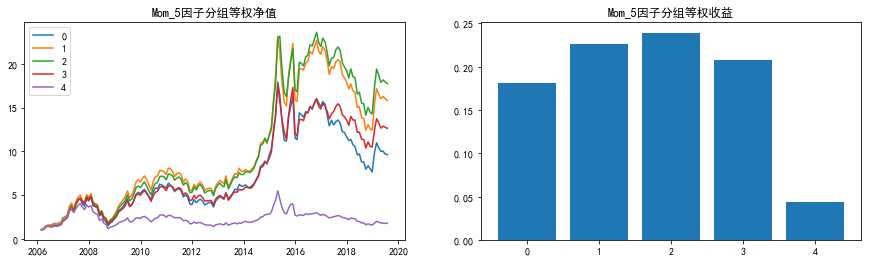

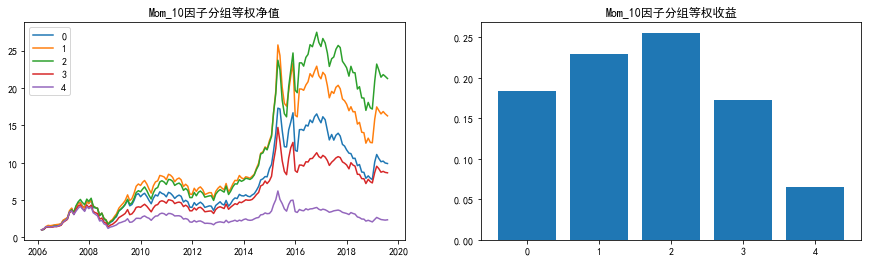

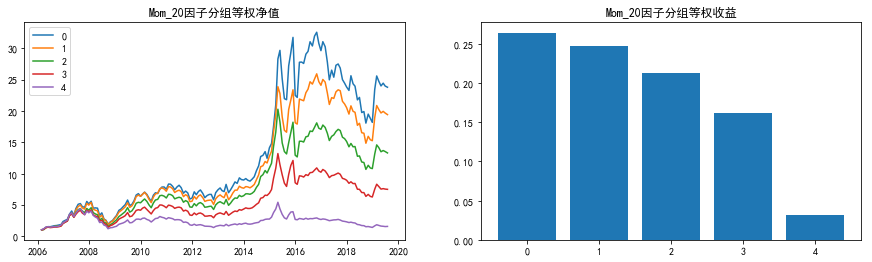

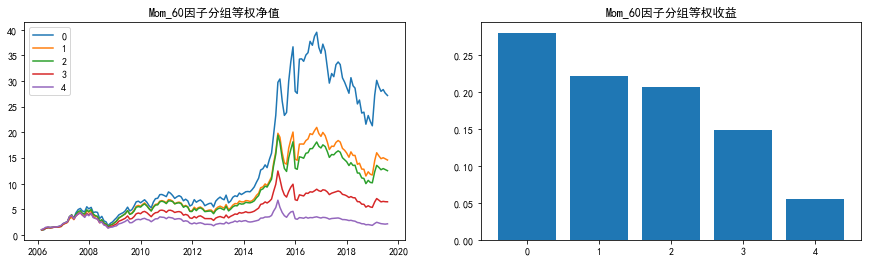

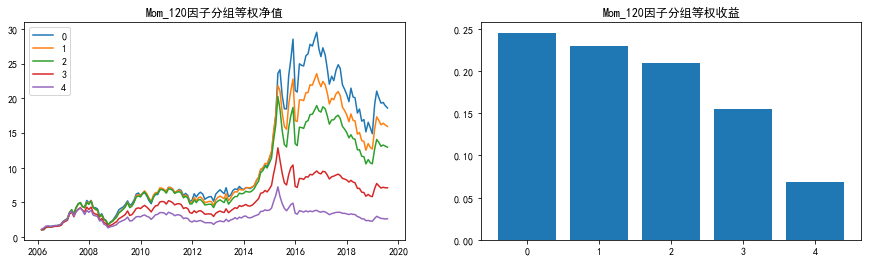

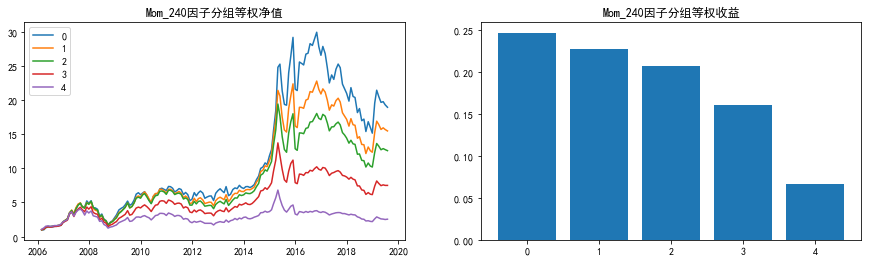

In [49]:
# 计算因子分组收益
def Cut(df,col,N):
    df_=df.copy()
    df_['G']=pd.qcut(df_[col],N,labels=False,duplicates='drop')
    return df_
def ComputYearlyRet(df,col):
    df_=df.sort_values('TRADE_DAYS').copy()
    last=(df_['TRADE_DAYS'].tolist()[-1]-df_['TRADE_DAYS'].tolist()[0]).days
    YearlyRet=(df_[col].tolist()[-1]/df_[col].tolist()[0])**(365.25/last)-1
    return YearlyRet

FacrotList=['Mom_'+str(c) for c in MomNList]
Used_FactorDf = BarraMomFct.copy()
for col in FacrotList:
    BarraFactorNextR_sub=Used_FactorDf[['S_INFO_WINDCODE','TRADE_DAYS','NextRet',col]].copy()
    BarraFactorNextR_sub0=BarraFactorNextR_sub.groupby('TRADE_DAYS').apply(Cut,col=col,N=5).reset_index(drop=True)
    BarraFactorNextR_sub1=BarraFactorNextR_sub0.groupby(['TRADE_DAYS','G']).mean().reset_index()
    FactorEquity=(BarraFactorNextR_sub1.pivot_table(index='TRADE_DAYS',columns='G',values='NextRet')+1).cumprod()
    FactorAvgR=BarraFactorNextR_sub1.groupby('G').mean()[['NextRet']]*12
    FactorYearlyR=FactorEquity.unstack().to_frame(col).reset_index().groupby('G').apply(ComputYearlyRet,col).to_frame(col)
    fig=plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,2,1)
    ax1.plot(FactorEquity)
    ax1.legend(FactorEquity.columns,loc=0)
    plt.title('%s因子分组等权净值'%(col))
    ax2=fig.add_subplot(1,2,2)
    # 年化收益
    ax2.bar(FactorYearlyR.index,FactorYearlyR[col])
    # 平均收益
#     ax2.bar(FactorAvgR.index,FactorAvgR['NextRet'])
    plt.title('%s因子分组等权收益'%(col))
    plt.show()

A股似乎并不存在长期动量效应，长期表现出单调性较好的反转特性。

## 低波动异象分解

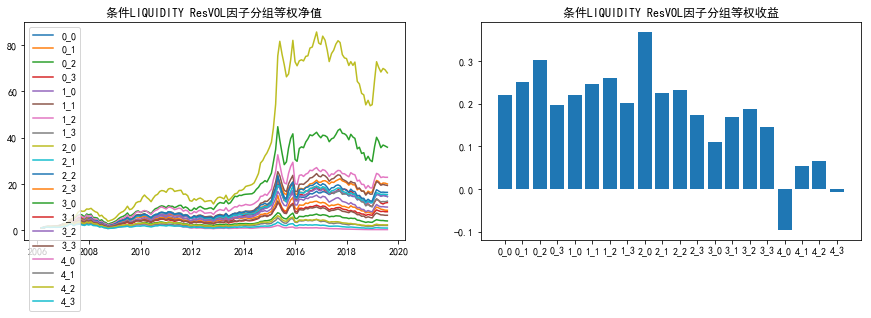

In [104]:
# 计算因子分组收益
def CutMulti(df,col,N):
    df_=df.copy()
    df_['G_%s'%(col)]=pd.qcut(df_[col],N,labels=False,duplicates='drop')
    return df_
def ComputYearlyRet(df,col):
    df_=df.sort_values('TRADE_DAYS').copy()
    last=(df_['TRADE_DAYS'].tolist()[-1]-df_['TRADE_DAYS'].tolist()[0]).days
    YearlyRet=(df_[col].tolist()[-1]/df_[col].tolist()[0])**(365.25/last)-1
    return YearlyRet

FacrotList=['Mom_'+str(c) for c in MomNList]
FacrotList=['ResVOL']
ConditionFct='LIQUIDITY'
Used_FactorDf = BarraMomFct.copy()
for col in FacrotList:
    BarraFactorNextR_sub=Used_FactorDf[['S_INFO_WINDCODE','TRADE_DAYS','NextRet',col,ConditionFct]].copy()
    BarraFactorNextR_sub0=BarraFactorNextR_sub.groupby('TRADE_DAYS').apply(CutMulti,col=col,N=4).reset_index(drop=True)
    BarraFactorNextR_sub1=BarraFactorNextR_sub0.groupby('TRADE_DAYS').apply(CutMulti,col=ConditionFct,N=5).reset_index(drop=True)
    BarraFactorNextR_sub2=BarraFactorNextR_sub1.groupby(['TRADE_DAYS','G_%s'%(col),'G_%s'%(ConditionFct)]).mean().reset_index()
    BarraFactorNextR_sub2['%s_Mom'%(ConditionFct)]=BarraFactorNextR_sub2['G_%s'%(ConditionFct)].apply(lambda x: str(x))+'_'+BarraFactorNextR_sub2['G_%s'%(col)].apply(lambda x: str(x))
    FactorEquity=(BarraFactorNextR_sub2.pivot_table(index='TRADE_DAYS',columns='%s_Mom'%(ConditionFct),values='NextRet')+1).cumprod()
    FactorAvgR=BarraFactorNextR_sub2.groupby('%s_Mom'%(ConditionFct)).mean()[['NextRet']]*12
    FactorYearlyR=FactorEquity.unstack().to_frame(col).reset_index().groupby('%s_Mom'%(ConditionFct)).apply(ComputYearlyRet,col).to_frame(col)
    fig=plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,2,1)
    ax1.plot(FactorEquity)
    ax1.legend(FactorEquity.columns,loc=0)
    plt.title('条件%s %s因子分组等权净值'%(ConditionFct,col))
    ax2=fig.add_subplot(1,2,2)
    # 年化收益
    ax2.bar(FactorYearlyR.index,FactorYearlyR[col])
    # 平均收益
#     ax2.bar(FactorAvgR.index,FactorAvgR['NextRet'])
    plt.title('条件%s %s因子分组等权收益'%(ConditionFct,col))
    plt.show()

全横截面上低波动异象是存在的，与理论“波动越低，风险越低，期望收益越低”相反；  
使用流动性对波动因子进行double-sort后，低波动异象得到一定解释：在流动性从低到高的5组中，第1、2、4、5组的组内收益均呈现出一致的走势——组内前3组收益随着波动增加单调递增，最大波动组收益较低；  
固定流动性后，组内的收益随着波动的增大而增大，与理论是相符合的，最大（历史）波动组似乎不被投资者偏好，可能意味着过大的不确定性，尾部风险的发生侵蚀了预期收益的一部分。

# 波动因子计算
为研究低风险异象，计算5类（可能增加）衡量风险的因子：  
1）普通波动率；  
$$ Vol_i=std(r_i) $$  
2) 非系统性风险；  
$$ r^{ex}_i=r_i-r_{bm} $$
$$ NsVol_i=std(r^{ex}_i) $$  
3) 残差波动率；  
$$ r_i=\alpha_i+\beta r_bm+\epsilon_i $$
$$ RVol_i = std(\epsilon_i) $$  
4) 系统性风险；  
$$ SVol_i=\beta_i $$  
5) 峰度，偏度；  
$$ SkVol_i，KuVol_i $$

## 行情数据

In [12]:
AllPriceData=DfForStock.copy()
AllPriceData_0 = AllPriceData[['S_INFO_WINDCODE','TRADE_DT','S_DQ_ADJCLOSE']].copy()
AllPriceData_0['TRADE_DAYS'] = AllPriceData_0['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(int(x)),'%Y%m%d') if not pd.isnull(x) else np.nan)
AllPriceData_1=AllPriceData_0[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()

## 指数数据

In [13]:
IndexHS300Weight = pd.read_csv('D:/DWDB/%s.csv'%('AIndexHS300FreeWeight'))
IndexHS300Weight['TRADE_DAYS'] = IndexHS300Weight['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))
IndexEODPrices = pd.read_csv('D:/DWDB/%s.csv'%('AIndexEODPrices'))
IndexEODPrices['TRADE_DAYS'] = IndexEODPrices['TRADE_DT'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

In [14]:
benchmarkI = '000905.SH'

In [15]:
IndexPrices=IndexEODPrices[IndexEODPrices['S_INFO_WINDCODE']==benchmarkI][['TRADE_DAYS','S_INFO_WINDCODE','S_DQ_CLOSE']].copy()
IndexPrices['基准指数']=IndexPrices['S_DQ_CLOSE']

## 收益率计算

In [16]:
# 个股行情数据，个股收益率
DfForRet=AllPriceData_1[['S_INFO_WINDCODE','TRADE_DAYS','S_DQ_ADJCLOSE']].copy()
def ComputeRet(df,datename,colname):
    df_=df.sort_values(datename).copy()
    df_['Ret']=df_[colname]/df_[colname].shift(1)-1
    return df_
DfForRet_0=DfForRet.groupby('S_INFO_WINDCODE').apply(ComputeRet,datename='TRADE_DAYS',colname='S_DQ_ADJCLOSE').reset_index(drop=True)

In [24]:
# 指数行情数据，指数收益率
DfForRet_Index=IndexPrices[['S_INFO_WINDCODE','TRADE_DAYS','基准指数']].copy()
DfForRet_Index_0=DfForRet_Index.groupby('S_INFO_WINDCODE').apply(ComputeRet,datename='TRADE_DAYS',colname='基准指数').reset_index(drop=True)
DfForRet_Index_1=DfForRet_Index_0.rename(columns={'Ret':'基准指数Ret'})

## 各类风险因子计算

In [21]:
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,axis=0)
def ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_2,ComputeBeta,StartN,UsedN):
    '''
    日度数据计算月度因子专用函数
    TradeDateDf_M_Used,循环交易日DF
    DfForRet_2,原材料数据集
    StartN,因子计算起始窗口
    UsedN,因子计算所需数据长度
    '''
    DateList=TradeDateDf_M_Used['TRADE_DAYS']
    SaveDf=pd.DataFrame()
    for DateCnt in range(StartN,len(DateList)):
        DateNow=DateList[DateCnt]
        DateLast=DateList[DateCnt-UsedN]
        DfForRet_2_sub=DfForRet_2[(DfForRet_2['TRADE_DAYS']<=DateNow)&(DfForRet_2['TRADE_DAYS']>=DateLast)].copy()
        DfForRet_2_sub0=DfForRet_2_sub[DfForRet_2_sub['S_INFO_WINDCODE'].isin(DfForStock_V[DfForStock_V['TRADE_DAYS']==DateNow]['S_INFO_WINDCODE'])]
        DfForRet_2_sub1=applyParallel(DfForRet_2_sub0.groupby('S_INFO_WINDCODE'),ComputeBeta)
        DfForRet_2_sub1['TRADE_DAYS']=DateNow
        SaveDf=pd.concat([SaveDf,DfForRet_2_sub1],axis=0)
    return SaveDf

In [22]:
# 普通波动率
def ComputeVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    Rprod=(df_['Ret'][-252:]).std()
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],Rprod],index=['S_INFO_WINDCODE','Vol']).T

In [23]:
Vol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_0.dropna(),ComputeVol,12,12)

In [30]:
# 非系统性风险
def ComputeNsVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    r_i=df_['Ret'][-252:]
    r_bm=df_['基准指数Ret'][-252:]
    r_ex=r_i-r_bm
    Rprod=r_ex.std()
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],Rprod],index=['S_INFO_WINDCODE','NsVol']).T

In [ ]:
DfForRet_1=DfForRet_0.merge(DfForRet_Index_1[['TRADE_DAYS','基准指数Ret']].copy(),on=['TRADE_DAYS'],how='left').dropna()
NsVol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_1,ComputeNsVol,12,12)

In [ ]:
# 残差波动率与非系统性风险
def ComputeR_SVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    r_i=df_['Ret'][-252:]
    r_bm=df_['基准指数Ret'][-252:]
    r_bm_c=sm.add_consatant(r_bm)
    RegResult=sm.OLS(r_i,r_bm_c).fit()
    beta=RegResult.params[1]
    rvol=np.std(RegResult.resid)
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],beta,rvol],index=['S_INFO_WINDCODE','SVol','RVol']).T

In [32]:
R_SVol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_1,ComputeNsVol,174,12)

,S_INFO_WINDCODE,NsVol,TRADE_DAYS
0,000001.SZ,0.0170732,2019-06-28
0,000002.SZ,0.0194296,2019-06-28
0,000004.SZ,0.0270225,2019-06-28
0,000005.SZ,0.0176899,2019-06-28
0,000006.SZ,0.0172024,2019-06-28
0,000007.SZ,0.0391175,2019-06-28
0,000008.SZ,0.0209389,2019-06-28
0,000009.SZ,0.0183156,2019-06-28
0,000011.SZ,0.0211761,2019-06-28
0,000012.SZ,0.0129935,2019-06-28


In [ ]:
# 峰度偏度
def ComputeK_FVol(df):
    df_=df.sort_values('TRADE_DAYS').copy()
    r_i=df_['Ret'][-252:]
    skew=r_i.skew()
    kurt=r_i.kurt()
    return pd.DataFrame([df_['S_INFO_WINDCODE'].tolist()[0],skew,kurt],index=['S_INFO_WINDCODE','SkVol','KuVol']).T

In [ ]:
R_SVol_Df=ComputeMfWithDData(TradeDateDf_M_Used,DfForRet_1,ComputeK_FVol,174,12)

## 与Barra因子合并